## Phase 1
### EEG Frequency Band Extraction

In this step, the raw EEG signals are decomposed into standard frequency bands using the Fast Fourier Transform (FFT).  
For each band, the corresponding frequency components are isolated, transformed back into the time domain with the inverse FFT,  
and then saved as a separate CSV file.

The frequency bands are:  
- **Delta (0–4 Hz)**  
- **Theta (4–8 Hz)**  
- **Alpha (8–12 Hz)**  
- **Beta (12–30 Hz)**  
- **Gamma (30–100 Hz)**


In [2]:
import os
import numpy as np
import pandas as pd

# === Input settings ===
file_path = r'E:\new adhd\raw-signals.xlsx'  # Path to your Excel file
fs = 640  # Sampling frequency in Hz

# === Load data ===
data = pd.read_excel(file_path, header=0)

# Separate metadata (ID, label) and raw signals
meta = data.iloc[:, :2].reset_index(drop=True)
X = data.iloc[:, 2:].to_numpy(dtype=float)   # shape: (num_records, num_timepoints)
n = X.shape[1]

# Real FFT (efficient for real-valued signals)
Xf = np.fft.rfft(X, axis=1)
freqs = np.fft.rfftfreq(n, d=1/fs)

# Define frequency bands with names
bands = [
    ('delta', (0, 4)),
    ('theta', (4, 8)),
    ('alpha', (8, 12)),
    ('beta',  (12, 30)),
    ('gamma', (30, 100)),
]

# Save directory = same as input file
save_dir = os.path.dirname(file_path)

# Band-pass filtering, reconstruction, and saving
for name, (f_lo, f_hi) in bands:
    # Frequency mask
    mask = (freqs >= f_lo) & (freqs < f_hi)

    # Keep only the frequencies inside this band
    Z = np.zeros_like(Xf)
    Z[:, mask] = Xf[:, mask]

    # Reconstruct time-domain signals
    X_band = np.fft.irfft(Z, n=n, axis=1)

    # Create output DataFrame
    df_out = pd.concat(
        [meta, pd.DataFrame(X_band, columns=data.columns[2:])],
        axis=1
    )

    # Save to CSV (file named after band name)
    out_path = os.path.join(save_dir, f'{name}.csv')
    df_out.to_csv(out_path, index=False)



### Feature Extraction from Alpha Band

This code loads the **alpha band signals** and computes a set of statistical and signal-processing features for each trial.  
The extracted features include:

- **Basic statistics:** Mean, Median, Variance, Amplitude, Positive/Negative Peaks  
- **Wavelet features (db4):** Mean of approximation/detail coefficients, Entropy of approximation/detail coefficients  
- **Entropy measures:** Histogram-based entropy  
- **Time-series features:** AR(1) coefficient, Hurst exponent (fractal measure)  
- **Signal power:** Mean squared amplitude  




In [4]:
import os
import numpy as np
import pandas as pd
import pywt
from scipy.stats import entropy

# =========================
# Paths
# =========================
alpha_path = r'E:\new adhd\alpha.csv'  # alpha band file you saved earlier
save_dir = os.path.dirname(alpha_path)
out_path = os.path.join(save_dir, 'alpha_features.csv')

# =========================
# Load alpha data
# Expecting first two columns: ID, Label; the rest are time samples
# =========================
df = pd.read_csv(alpha_path)
meta = df.iloc[:, :2].reset_index(drop=True)      # ID, Label
signals = df.iloc[:, 2:].to_numpy(dtype=float)    # shape: (n_signals, n_timepoints)

# =========================
# Helper functions
# =========================
def safe_pos_peak(x):
    """Max positive value, or 0 if none."""
    pos = x[x > 0]
    return float(pos.max()) if pos.size > 0 else 0.0

def safe_neg_peak(x):
    """Min negative value, or 0 if none."""
    neg = x[x < 0]
    return float(neg.min()) if neg.size > 0 else 0.0

def wavelet_db4_means(x):
    """One-level DWT (db4); return means of cA and cD."""
    cA, cD = pywt.dwt(x, 'db4')
    return float(np.mean(cA)), float(np.mean(cD))

def wavelet_db4_entropies(x, base=2):
    """Shannon entropy of |coeff|^2 for cA and cD."""
    cA, cD = pywt.dwt(x, 'db4')
    pA = np.abs(cA)**2
    pD = np.abs(cD)**2
    # avoid zeros by adding tiny epsilon before normalization
    pA = pA / (pA.sum() + np.finfo(float).eps)
    pD = pD / (pD.sum() + np.finfo(float).eps)
    return float(entropy(pA + np.finfo(float).eps, base=base)), float(entropy(pD + np.finfo(float).eps, base=base))

def histogram_entropy(x, base=2, bins='auto'):
    """Histogram-based entropy of the signal."""
    hist, edges = np.histogram(x, bins=bins, density=True)
    probs = hist * np.diff(edges)
    # guard against zeros
    probs = probs + np.finfo(float).eps
    probs = probs / probs.sum()
    return float(entropy(probs, base=base))

def ar1_coefficient(x):
    """
    AR(1) phi via least squares:
        minimize ||y_t - phi * y_{t-1}||^2
        phi = sum(y_t * y_{t-1}) / sum(y_{t-1}^2)
    """
    y_t = x[1:]
    y_tm1 = x[:-1]
    denom = np.dot(y_tm1, y_tm1) + np.finfo(float).eps
    phi = float(np.dot(y_t, y_tm1) / denom)
    return phi

def hurst_exponent(x):
    """
    Hurst exponent via R/S-like slope on log scales (lag 2..99).
    Not a perfect estimator, but a compact fractal feature.
    """
    lags = np.arange(2, min(100, len(x) - 1))
    if lags.size == 0:
        return np.nan
    # std of lagged differences
    tau = np.array([np.sqrt(np.std(x[lag:] - x[:-lag])) for lag in lags], dtype=float)
    # replace inf/nan with small positive
    tau[~np.isfinite(tau)] = np.finfo(float).eps
    # linear fit in log-log
    coeffs = np.polyfit(np.log10(lags), np.log10(tau + np.finfo(float).eps), 1)
    # as in your earlier code: slope * 2.0
    return float(coeffs[0] * 2.0)

def band_power(x):
    """Mean squared value (power) of the signal."""
    return float(np.mean(x**2))

# =========================
# Feature extraction
# =========================
rows = []
for i in range(signals.shape[0]):
    sig = signals[i, :]

    mean_val   = float(np.mean(sig))
    median_val = float(np.median(sig))
    var_val    = float(np.var(sig))
    amp_val    = float(np.max(sig) - np.min(sig))
    pos_peak   = safe_pos_peak(sig)
    neg_peak   = safe_neg_peak(sig)

    cA_mean, cD_mean = wavelet_db4_means(sig)
    cA_ent,  cD_ent  = wavelet_db4_entropies(sig, base=2)
    hist_ent         = histogram_entropy(sig, base=2, bins='auto')
    phi_ar1          = ar1_coefficient(sig)
    hurst_val        = hurst_exponent(sig)
    pwr_val          = band_power(sig)

    rows.append([
        mean_val, median_val, var_val, amp_val,
        pos_peak, neg_peak,
        cA_mean, cD_mean,
        cA_ent, cD_ent,
        hist_ent,
        phi_ar1,
        hurst_val,
        pwr_val
    ])

feature_cols = [
    'Mean',
    'Median',
    'Variance',
    'Amplitude',
    'Positive Peak Amplitude',
    'Negative Peak Amplitude',
    'Wavelet cA Mean (db4)',
    'Wavelet cD Mean (db4)',
    'Wavelet cA Entropy (bits)',
    'Wavelet cD Entropy (bits)',
    'Histogram Entropy (bits)',
    'AR(1) Coefficient',
    'Hurst Exponent',
    'Band Power'
]

features_df = pd.DataFrame(rows, columns=feature_cols)

# Bring back ID/Label as the first two columns
out_df = pd.concat([meta, features_df], axis=1)




## Phase 2
### EDA & Feature Analysis (Alpha Band)

This phase explores the **alpha_features.csv** dataset and assesses which features best separate **Normal vs ADHD**.

**What’s included**
- **Data overview:** preview, shape, `info()`, and summary stats.
- **Distributions by class:** KDE plots for **every numeric feature** (excluding `ID/Label`) with Normal vs ADHD overlays.
- **Univariate discriminativeness:** for each feature, compute **ROC AUC**, **Cohen’s d**, **Welch t-test**, **Mann–Whitney U**, **ANOVA F**, and **Mutual Information**, with **FDR** correction; build a **combined rank**.
- **Visual outputs:** bar charts of **Top features by ROC AUC** and by **|Cohen’s d|**.
- **Artifacts:** full ranked table saved as **`alpha_feature_ranking.csv`** (next to the data file).

**How to read**
- Clear class separation in KDEs ⇒ feature likely useful.
- Higher **AUC**, larger **|Cohen’s d|**, higher **MI/F**, and **FDR-adjusted p < 0.05** ⇒ stronger discriminative power.


# Dataset Overview

In [5]:
import pandas as pd

# Path to your extracted alpha features file
file_path = r'E:\new adhd\alpha_features.csv'

# Load dataset
df = pd.read_csv(file_path)

# Show first few rows
print("🔹 First 5 rows:")
display(df.head())

# Dataset shape
print(f"\n🔹 Dataset shape: {df.shape} (rows, columns)")

# Info (column types, non-null counts, memory usage)
print("\n🔹 Dataset info:")
print(df.info())

# Basic statistics for numerical features
print("\n🔹 Statistical summary:")
display(df.describe())

🔹 First 5 rows:


,ID,label,Mean,Median,Variance,Amplitude,Positive Peak Amplitude,Negative Peak Amplitude,Wavelet cA Mean (db4),Wavelet cD Mean (db4),Wavelet cA Entropy (bits),Wavelet cD Entropy (bits),Histogram Entropy (bits),AR(1) Coefficient,Hurst Exponent,Band Power
0,subject 1,normal,2.775558e-18,0.001588,0.347196,2.066541,1.022501,-1.044041,0.002764,4.017199e-08,7.815398,2.311132,3.395456,0.995307,0.183656,0.347196
1,subject 2,normal,1.665335e-17,-0.000562,0.775340,3.436358,1.711551,-1.724807,-0.003056,1.181702e-07,7.734707,2.312459,3.340494,0.995442,0.190529,0.775340
2,subject 3,normal,-1.110223e-17,0.002477,3.554966,8.630261,4.271582,-4.358679,-0.008810,1.272169e-07,7.303432,2.379448,3.669292,0.995266,0.200717,3.554966
3,subject 4,normal,2.775558e-18,-0.006795,0.221049,2.192589,1.067510,-1.125079,0.007268,-7.874404e-09,7.403280,2.280086,3.649127,0.996210,0.170536,0.221049
4,subject 5,normal,0.000000e+00,-0.026662,0.549254,3.448057,1.706799,-1.741258,0.015511,-1.721367e-07,7.490526,2.282917,3.565728,0.996113,0.160062,0.549254



🔹 Dataset shape: (360, 16) (rows, columns)

🔹 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         360 non-null    object 
 1   label                      360 non-null    object 
 2   Mean                       360 non-null    float64
 3   Median                     360 non-null    float64
 4   Variance                   360 non-null    float64
 5   Amplitude                  360 non-null    float64
 6   Positive Peak Amplitude    360 non-null    float64
 7   Negative Peak Amplitude    360 non-null    float64
 8   Wavelet cA Mean (db4)      360 non-null    float64
 9   Wavelet cD Mean (db4)      360 non-null    float64
 10  Wavelet cA Entropy (bits)  360 non-null    float64
 11  Wavelet cD Entropy (bits)  360 non-null    float64
 12  Histogram Entropy (bits)   360 non-null    fl

,Mean,Median,Variance,Amplitude,Positive Peak Amplitude,Negative Peak Amplitude,Wavelet cA Mean (db4),Wavelet cD Mean (db4),Wavelet cA Entropy (bits),Wavelet cD Entropy (bits),Histogram Entropy (bits),AR(1) Coefficient,Hurst Exponent,Band Power
count,3.600000e+02,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,3.600000e+02,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,-1.829892e-19,-0.003073,0.883331,3.706126,1.848817,-1.857309,0.002685,-2.730665e-08,7.468877,2.797109,3.563400,0.995859,0.201360,0.883331
std,6.654975e-18,0.030291,0.909487,1.753126,0.872321,0.882354,0.011152,3.422545e-07,0.180718,1.172034,0.164500,0.000486,0.025993,0.909487
min,-2.498002e-17,-0.146609,0.000082,0.041053,0.019774,-6.006087,-0.028018,-1.079990e-06,6.871477,2.273371,3.319501,0.994329,0.115228,0.000082
25%,-2.775558e-18,-0.017378,0.347196,2.533387,1.263105,-2.203867,-0.003361,-2.127343e-07,7.361580,2.309598,3.420943,0.995481,0.181069,0.347196
50%,0.000000e+00,-0.001142,0.611186,3.373830,1.689430,-1.694229,0.002764,-6.465345e-08,7.490814,2.363442,3.538355,0.995904,0.204126,0.611186
75%,2.775558e-18,0.009767,1.060686,4.425974,2.222515,-1.259597,0.009484,1.272169e-07,7.593152,2.516501,3.668796,0.996232,0.220245,1.060686
max,3.330669e-17,0.105249,6.991123,11.944276,5.938189,-0.021279,0.052413,9.848971e-07,7.828674,7.443646,4.108740,0.996829,0.256931,6.991123


# Data visualization

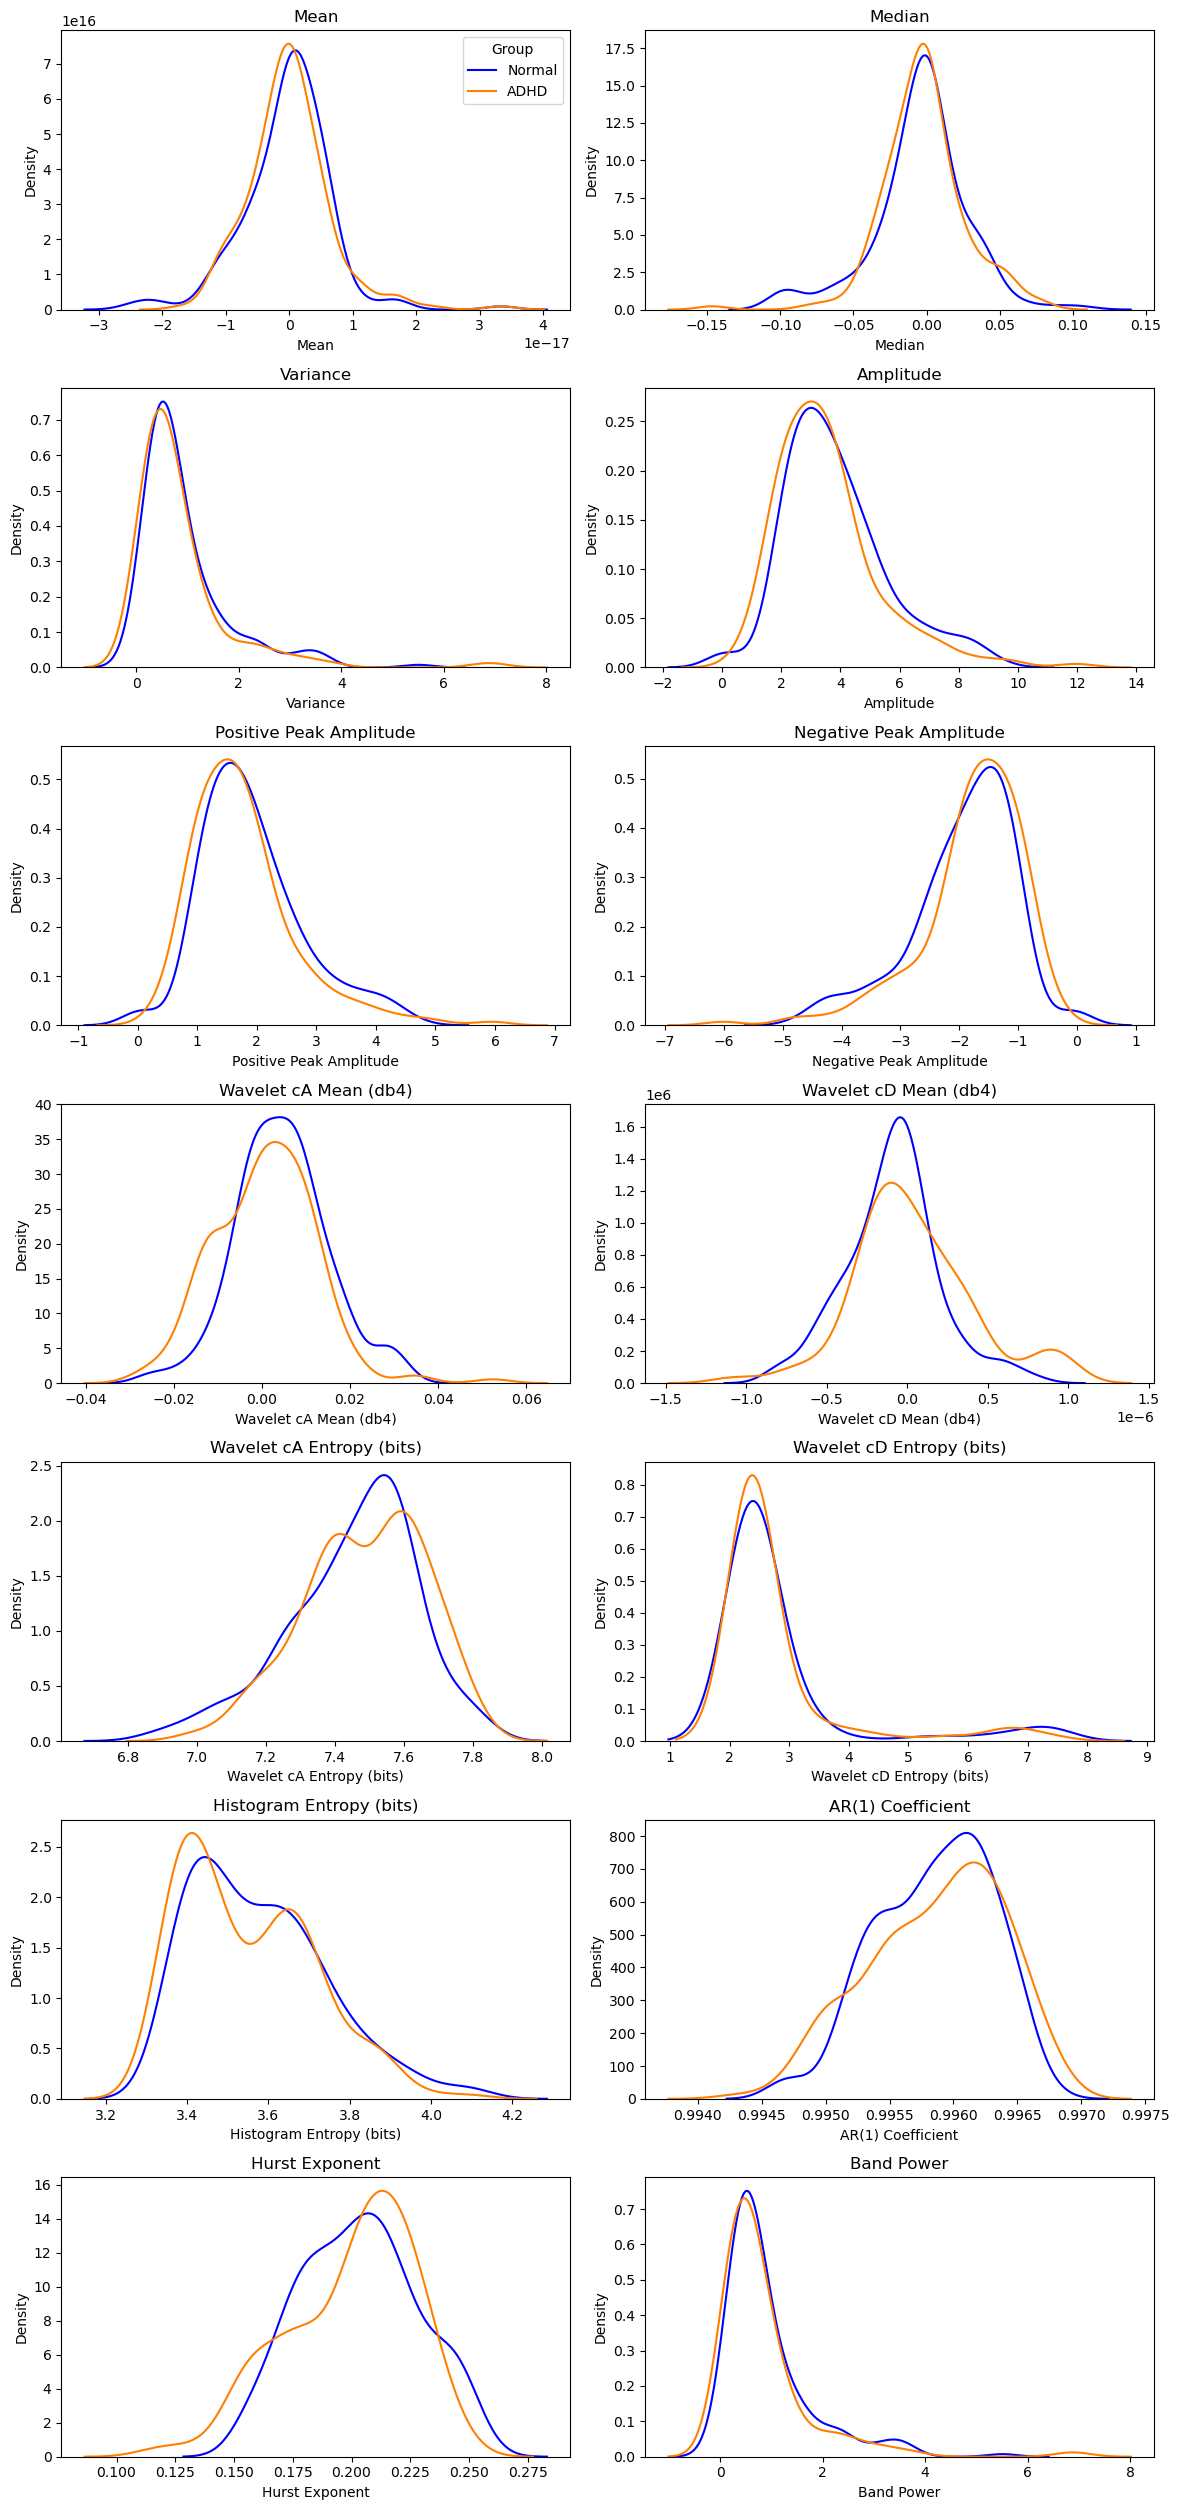

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# ---- Load ----
file_path = r'E:\new adhd\alpha_features.csv'
df = pd.read_csv(file_path)

# ---- Standardize column names & label column ----
df.columns = [c.strip() for c in df.columns]
if 'label' in df.columns and 'Label' not in df.columns:
    df = df.rename(columns={'label': 'Label'})

# ---- Map labels to 'Normal' / 'ADHD' ----
def to_normal_adhd(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # numeric 0/1 labels
    try:
        v = float(s)
        return 'ADHD' if v == 1 else 'Normal'
    except ValueError:
        pass
    # textual labels
    if s in {'adhd', 'patient', 'case', 'affected'}:
        return 'ADHD'
    if s in {'normal', 'control', 'healthy'}:
        return 'Normal'
    # fallback: contains 'adhd' → ADHD, otherwise Normal
    return 'ADHD' if 'adhd' in s else 'Normal'

df['Label'] = df['Label'].apply(to_normal_adhd)

# ---- Pick all numeric feature columns (exclude ID & Label if numeric) ----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['ID', 'Label']:
    if col in num_cols:
        num_cols.remove(col)
feature_cols = num_cols

# ---- Figure layout: 2 columns, rows auto ----
n_features = len(feature_cols)
n_cols = 2
n_rows = ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.6 * n_rows))
axes = np.atleast_1d(axes).ravel()

palette = {'Normal': '#0000FF', 'ADHD': '#FF7F00'}  # blue/orange

# ---- Plot KDE for each feature ----
for i, feat in enumerate(feature_cols):
    ax = axes[i]
    tmp = df[['Label', feat]].dropna()

    for grp in ['Normal', 'ADHD']:
        if grp in tmp['Label'].unique():
            series = tmp.loc[tmp['Label'] == grp, feat]
            if series.nunique() > 1:
                sns.kdeplot(
                    series,
                    ax=ax,
                    fill=False,
                    common_norm=False,
                    label=grp if i == 0 else None,
                    color=palette[grp]
                )
            else:
                # Fallback if the distribution is (almost) constant
                ax.axvline(series.iloc[0], linestyle='--', color=palette[grp], label=grp if i == 0 else None)

    ax.set_title(feat)
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend only once (on the first subplot)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(title='Group')

fig.tight_layout()
plt.show()


### Feature Discriminativeness Ranking (Normal vs ADHD) — Alpha Band

This cell loads `alpha_features.csv`, standardizes labels to **Normal/ADHD**, evaluates **every numeric feature** (excluding `ID`/`Label`), and ranks them by how well they separate the two classes.

**Metrics (per feature)**
- **ROC AUC** (direction-agnostic; closer to 1 = better separation)
- **Cohen’s d** (effect size; larger |d| = stronger difference)
- **Welch t-test** and **Mann–Whitney U** (two-group tests; **FDR**-corrected p-values)
- **ANOVA F** and **Mutual Information (MI)**

**Procedure**
1. Load and clean data; normalize labels (Normal/ADHD).
2. Compute all metrics per feature.
3. Apply Benjamini–Hochberg **FDR** to control multiple testing.
4. Build a **combined rank** (average rank of AUC, |d|, MI, F) and sort features.

**Outputs**
- A sorted table of features with all metrics.
- Saved CSV: **`alpha_feature_ranking.csv`** (next to the data file).
- Two bar plots: **Top by ROC AUC** and **Top by |Cohen’s d|**  
  *(If |d| is undefined/zero for all features, the code prints a note instead of plotting.)*


Using 14 numeric features:
['Mean', 'Median', 'Variance', 'Amplitude', 'Positive Peak Amplitude', 'Negative Peak Amplitude', 'Wavelet cA Mean (db4)', 'Wavelet cD Mean (db4)', 'Wavelet cA Entropy (bits)', 'Wavelet cD Entropy (bits)', 'Histogram Entropy (bits)', 'AR(1) Coefficient', 'Hurst Exponent', 'Band Power'] 

Top 10 discriminative features (combined rank):


,Feature,ROC_AUC,Cohen_d,MutualInfo,ANOVA_F,t_p_FDR,MWU_p_FDR,ANOVA_p_FDR,Direction
0,Wavelet cD Mean (db4),0.595432,NaN,0.139877,13.207684,0.004518,0.012178,0.004475,ADHD > Normal
1,Negative Peak Amplitude,0.568179,0.182165,0.157627,2.986583,0.196132,0.073629,0.196130,ADHD > Normal
2,Amplitude,0.568488,-0.179742,0.154647,2.907659,0.196132,0.073629,0.196130,Normal > ADHD
3,Wavelet cA Mean (db4),0.598272,-0.360001,0.111486,11.664072,0.004977,0.012178,0.004972,Normal > ADHD
4,Positive Peak Amplitude,0.567716,-0.176971,0.190890,2.818672,0.196132,0.073629,0.196130,Normal > ADHD
5,Wavelet cA Entropy (bits),0.551296,0.195453,0.137498,3.438152,0.196132,0.144016,0.196130,ADHD > Normal
6,Variance,0.557160,-0.084892,0.191716,0.648599,0.536017,0.121476,0.536007,Normal > ADHD
7,Band Power,0.557160,-0.084892,0.191716,0.648599,0.536017,0.121476,0.536007,Normal > ADHD
8,Histogram Entropy (bits),0.551265,-0.174835,0.124527,2.751070,0.196132,0.144016,0.196130,Normal > ADHD
9,Hurst Exponent,0.522870,-0.162037,0.118873,2.363038,0.218980,0.634508,0.218966,Normal > ADHD



Saved full ranking to: E:\new adhd\alpha_feature_ranking.csv


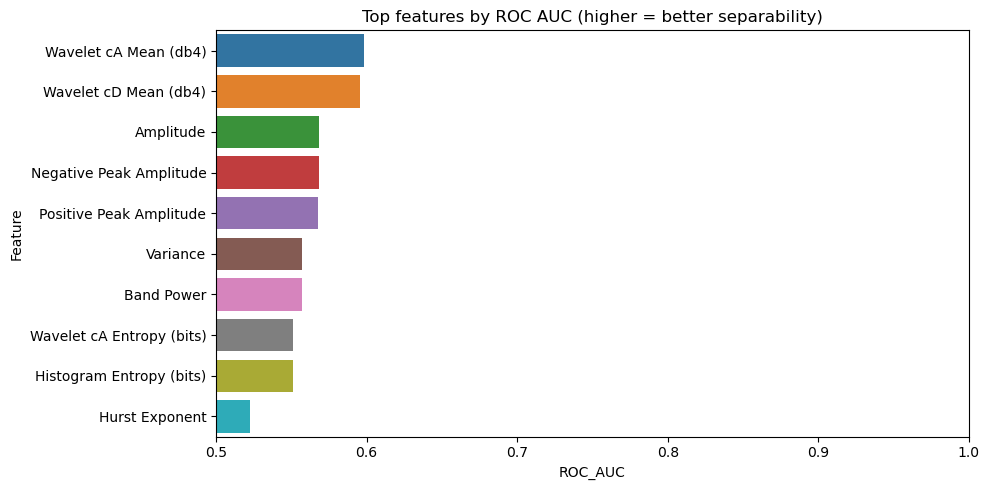

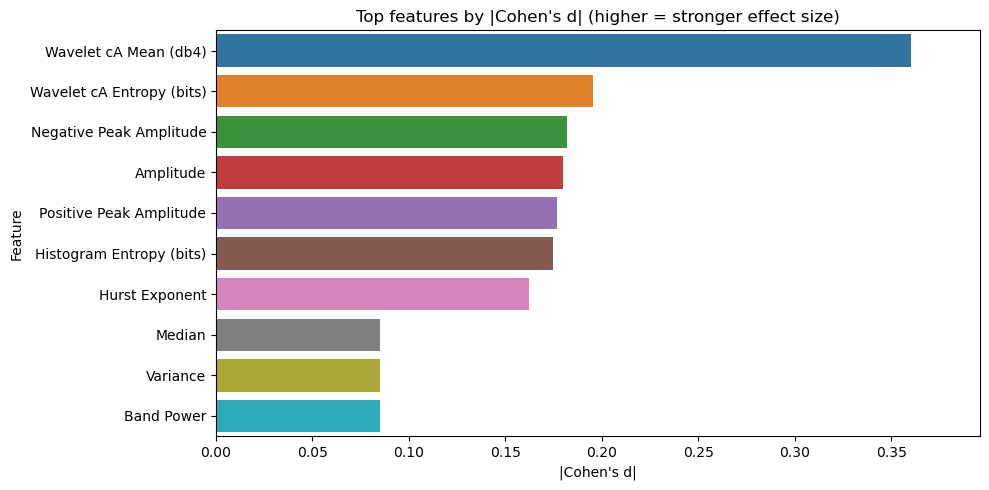

In [14]:
# ===========================
# Discriminative Feature Ranking (Normal vs ADHD)
# ===========================
# - Loads alpha_features.csv
# - Normalizes labels to Normal / ADHD
# - Computes per-feature metrics: ROC AUC, Cohen's d, Welch t-test, Mann–Whitney U,
#   ANOVA F, Mutual Information + FDR corrections
# - Builds a combined rank and shows Top features
# - Robust barplots (top by AUC and by |Cohen's d|)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_classif, mutual_info_classif
from statsmodels.stats.multitest import multipletests

# -----------------------------
# 1) Load data
# -----------------------------
file_path = r'E:\new adhd\alpha_features.csv'  # <-- change if needed
df = pd.read_csv(file_path)

# Clean column names and ensure "Label" exists
df.columns = [c.strip() for c in df.columns]
if 'label' in df.columns and 'Label' not in df.columns:
    df = df.rename(columns={'label': 'Label'})

# -----------------------------
# 2) Normalize labels to Normal / ADHD
# -----------------------------
def to_normal_adhd(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # numeric 0/1?
    try:
        v = float(s)
        return 'ADHD' if v == 1 else 'Normal'
    except ValueError:
        pass
    # textual variants
    if s in {'adhd', 'patient', 'case', 'affected'}:
        return 'ADHD'
    if s in {'normal', 'control', 'healthy'}:
        return 'Normal'
    # fallback: contains 'adhd' => ADHD, otherwise Normal
    return 'ADHD' if 'adhd' in s else 'Normal'

df['Label'] = df['Label'].apply(to_normal_adhd)
df = df.dropna(subset=['Label']).reset_index(drop=True)

y = df['Label'].map({'Normal': 0, 'ADHD': 1}).astype(int).values

# -----------------------------
# 3) Choose numeric feature columns
# -----------------------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop potential non-feature numeric columns
for col in ['ID', 'Label', 'Unnamed: 0']:
    if col in num_cols:
        num_cols.remove(col)

feature_cols = num_cols
X = df[feature_cols].values

print(f"Using {len(feature_cols)} numeric features:")
print(feature_cols, "\n")

# -----------------------------
# 4) Helper: Cohen's d
# -----------------------------
def cohens_d(x_ad, x_norm):
    x_ad = np.asarray(x_ad); x_norm = np.asarray(x_norm)
    nx, ny = len(x_ad), len(x_norm)
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = x_ad.var(ddof=1), x_norm.var(ddof=1)
    pooled = ((nx - 1) * vx + (ny - 1) * vy) / max(nx + ny - 2, 1)
    if pooled <= 1e-12:
        return np.nan
    return (x_ad.mean() - x_norm.mean()) / np.sqrt(pooled)

# -----------------------------
# 5) Compute metrics per feature
# -----------------------------
results = []

# Vectorized ANOVA F & MI
try:
    F_vals, p_anova = f_classif(X, y)
except Exception:
    F_vals = np.full(len(feature_cols), np.nan)
    p_anova = np.full(len(feature_cols), np.nan)

try:
    mi_vals = mutual_info_classif(X, y, random_state=0)
except Exception:
    mi_vals = np.full(len(feature_cols), np.nan)

for i, feat in enumerate(feature_cols):
    col = df[feat]
    mask = col.notna()
    xx = col[mask].values
    yy = y[mask]

    x_norm = xx[yy == 0]
    x_adhd = xx[yy == 1]

    # Welch t-test (robust to unequal variances)
    t_stat, p_t = ttest_ind(x_adhd, x_norm, equal_var=False, nan_policy='omit')

    # Mann–Whitney U (non-parametric)
    try:
        u_stat, p_mw = mannwhitneyu(x_adhd, x_norm, alternative='two-sided', method='auto')
    except ValueError:
        p_mw = np.nan

    # Cohen's d
    d = cohens_d(x_adhd, x_norm)
    mean_diff = float(np.nanmean(x_adhd) - np.nanmean(x_norm))
    direction = 'ADHD > Normal' if mean_diff > 0 else 'Normal > ADHD'

    # ROC AUC (direction-agnostic)
    auc = np.nan
    try:
        auc_raw = roc_auc_score(yy, xx)
        auc = max(auc_raw, 1 - auc_raw)
    except Exception:
        pass

    results.append({
        'Feature': feat,
        'Cohen_d': d,
        'MeanDiff(ADHD-Normal)': mean_diff,
        'Direction': direction,
        't_p': p_t,
        'MWU_p': p_mw,
        'ROC_AUC': auc,
        'ANOVA_F': F_vals[i],
        'ANOVA_p': p_anova[i],
        'MutualInfo': mi_vals[i],
    })

res = pd.DataFrame(results)

# -----------------------------
# 6) Multiple testing (FDR)
# -----------------------------
res['t_p_FDR'] = multipletests(res['t_p'].fillna(1.0), method='fdr_bh')[1]
res['MWU_p_FDR'] = multipletests(res['MWU_p'].fillna(1.0), method='fdr_bh')[1]
res['ANOVA_p_FDR'] = multipletests(res['ANOVA_p'].fillna(1.0), method='fdr_bh')[1]

# -----------------------------
# 7) Combined ranking
# -----------------------------
res['rank_auc']  = (-res['ROC_AUC']).rank(method='average')
res['rank_absd'] = (-res['Cohen_d'].abs()).rank(method='average')
res['rank_mi']   = (-res['MutualInfo']).rank(method='average')
res['rank_F']    = (-res['ANOVA_F']).rank(method='average')
res['RankAvg']   = res[['rank_auc','rank_absd','rank_mi','rank_F']].mean(axis=1)

res_sorted = res.sort_values('RankAvg').reset_index(drop=True)

print("Top 10 discriminative features (combined rank):")
display(res_sorted[['Feature','ROC_AUC','Cohen_d','MutualInfo','ANOVA_F',
                    't_p_FDR','MWU_p_FDR','ANOVA_p_FDR','Direction']].head(10))

# Optional: save full table next to the data file
out_csv = os.path.join(os.path.dirname(file_path), 'alpha_feature_ranking.csv')
res_sorted.to_csv(out_csv, index=False)
print(f"\nSaved full ranking to: {out_csv}")

# -----------------------------
# 8) Robust plotting
# -----------------------------
topk = min(10, len(res_sorted))

# ---- Top by ROC AUC
df_auc = (
    res[['Feature', 'ROC_AUC']]
    .dropna()
    .sort_values('ROC_AUC', ascending=False)
    .head(topk)
)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_auc, x='ROC_AUC', y='Feature')
plt.title('Top features by ROC AUC (higher = better separability)')
plt.xlim(0.5, 1.0)  # 0.5 ≈ random
plt.tight_layout()
plt.show()

# ---- Top by |Cohen's d|
df_d = res[['Feature', 'Cohen_d']].copy()
df_d['AbsD'] = df_d['Cohen_d'].abs()
df_d = df_d.replace([np.inf, -np.inf], np.nan).dropna(subset=['AbsD'])

if df_d.empty or (df_d['AbsD'] == 0).all():
    print("Cohen's d is NaN/zero for all features (possibly near-zero within-class variance).")
else:
    df_d = df_d.sort_values('AbsD', ascending=False).head(topk)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_d, x='AbsD', y='Feature')
    plt.title("Top features by |Cohen's d| (higher = stronger effect size)")
    plt.xlabel("|Cohen's d|")
    max_absd = float(df_d['AbsD'].max())
    plt.xlim(0, max_absd * 1.1 if max_absd > 0 else 0.1)
    plt.tight_layout()
    plt.show()


### Correlation Analysis — Alpha Band Features

This cell loads `alpha_features.csv`, cleans column names, and normalizes labels to **Normal/ADHD**.  
It then analyzes correlations in two ways:

1) **Feature–Feature Correlation (Heatmap)**  
   - Computes the Pearson correlation among all numeric features (excluding `ID`/`Label`).  
   - Plots a lower-triangle heatmap to highlight redundant (highly correlated) features.

2) **Correlation with Label (Bar Chart)**  
   - Maps labels to `Normal=0`, `ADHD=1` and computes Pearson correlation of each feature with the label.  
   - Ranks and plots features by |correlation| to reveal which ones align most with the class.

> Tip: Switch to `method='spearman'` for rank-based, outlier-robust correlation.


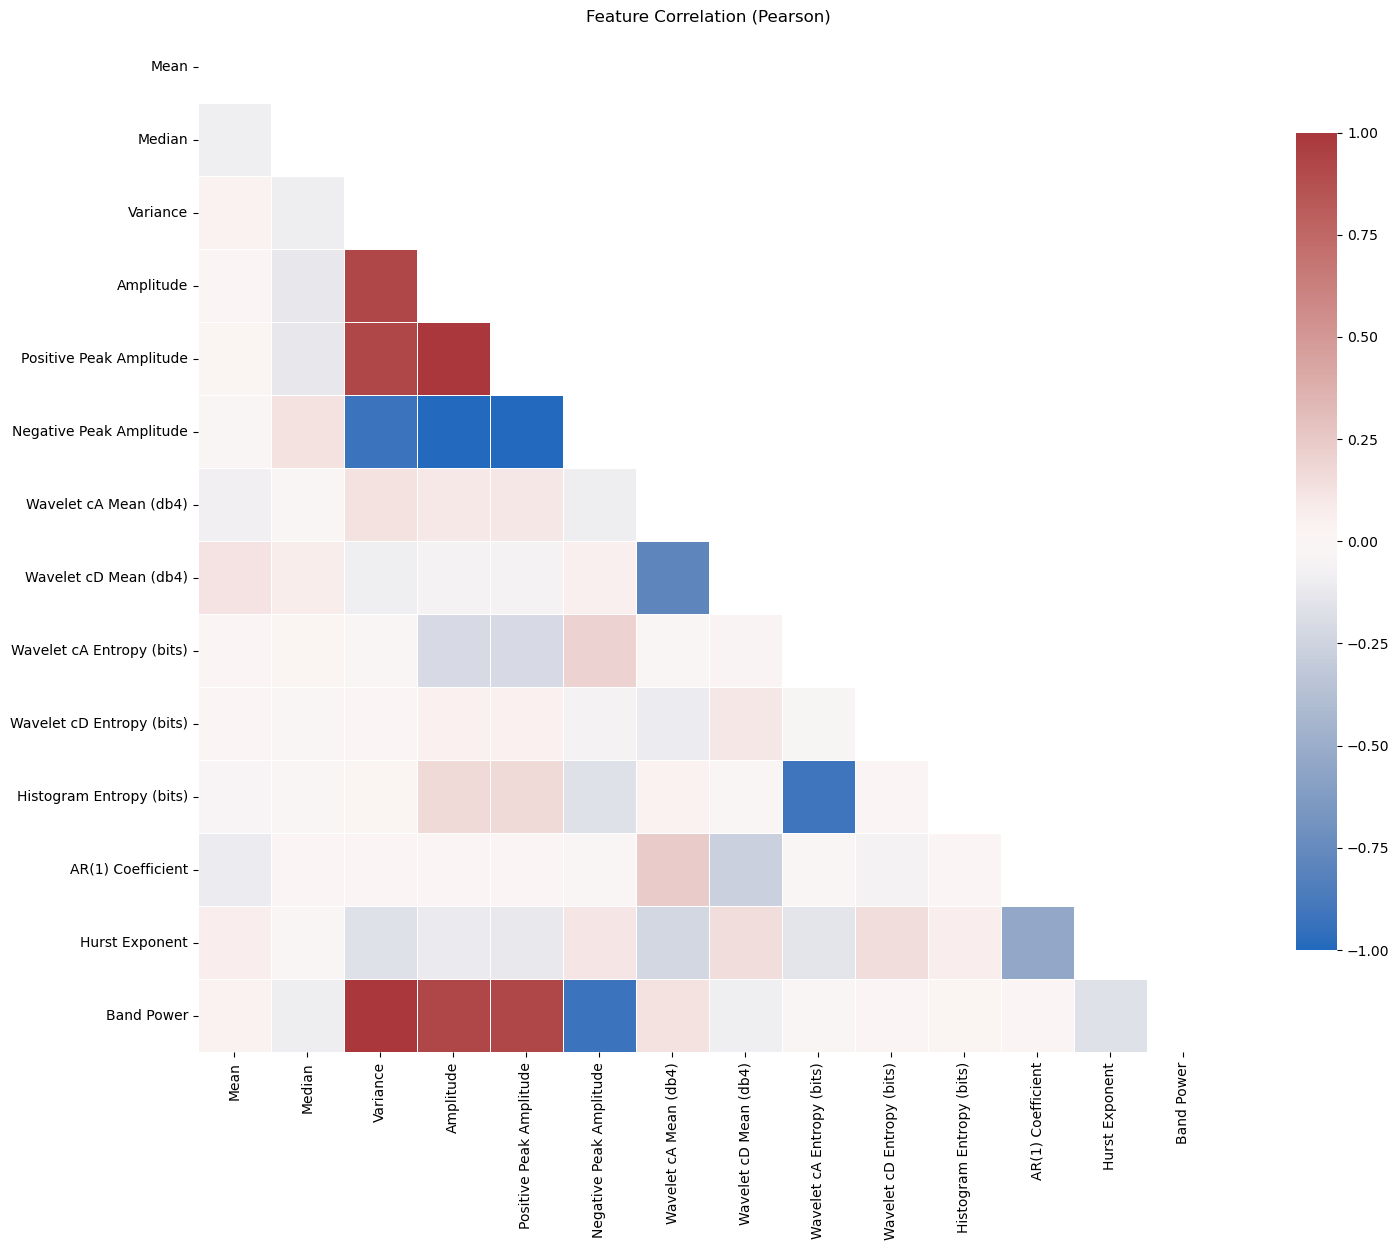

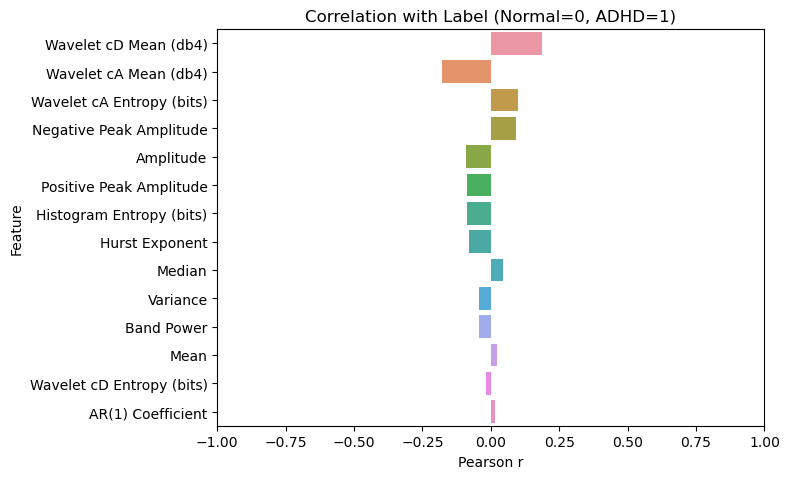

Top features by |correlation with Label|:
Wavelet cD Mean (db4)        0.188627
Wavelet cA Mean (db4)       -0.177632
Wavelet cA Entropy (bits)    0.097532
Negative Peak Amplitude      0.090958
Amplitude                   -0.089758
Positive Peak Amplitude     -0.088385
Histogram Entropy (bits)    -0.087327
Hurst Exponent              -0.080978
Median                       0.042563
Variance                    -0.042526
dtype: float64


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Load & clean ----------
file_path = r'E:\new adhd\alpha_features.csv'
df = pd.read_csv(file_path)

# standardize column names and ensure "Label"
df.columns = [c.strip() for c in df.columns]
if 'label' in df.columns and 'Label' not in df.columns:
    df = df.rename(columns={'label': 'Label'})

# normalize labels to Normal / ADHD
def to_normal_adhd(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    try:
        v = float(s)
        return 'ADHD' if v == 1 else 'Normal'
    except ValueError:
        pass
    if s in {'adhd', 'patient', 'case', 'affected'}: return 'ADHD'
    if s in {'normal', 'control', 'healthy'}: return 'Normal'
    return 'ADHD' if 'adhd' in s else 'Normal'

df['Label'] = df['Label'].apply(to_normal_adhd)
df = df.dropna(subset=['Label']).reset_index(drop=True)

# numeric features (exclude ID/Label if numeric)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['ID', 'Label']:
    if col in num_cols:
        num_cols.remove(col)
feature_cols = num_cols

# ---------- 1) Feature–Feature correlation heatmap ----------
corr = df[feature_cols].corr(method='pearson')  # or 'spearman' if you prefer rank correlation

mask = np.triu(np.ones_like(corr, dtype=bool))  # upper-triangle mask for cleaner look

plt.figure(figsize=(1.2*len(feature_cols), 0.9*len(feature_cols)))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='vlag', center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .8})
plt.title('Feature Correlation (Pearson)')
plt.tight_layout()
plt.show()

# ---------- 2) Correlation with Label (point-biserial via Pearson to 0/1) ----------
df['LabelNum'] = df['Label'].map({'Normal': 0, 'ADHD': 1}).astype(int)
label_corr = df[feature_cols].corrwith(df['LabelNum'], method='pearson').sort_values(key=lambda s: s.abs(), ascending=False)

plt.figure(figsize=(8, max(4, 0.35*len(feature_cols))))
sns.barplot(x=label_corr.values, y=label_corr.index, orient='h')
plt.title('Correlation with Label (Normal=0, ADHD=1)')
plt.xlabel('Pearson r')
plt.ylabel('Feature')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

# Optional: print the top correlations
print("Top features by |correlation with Label|:")
print(label_corr.head(10))


## Phase 3 
### Modeling & Evaluation (Normal vs ADHD)

This phase builds and compares classifiers on **alpha_features.csv**.

**Pipeline**
- Clean data, normalize labels (**Normal/ADHD**), select numeric features.
- **Train/Test split** (stratified).
- **Pipelines** with imputation (+ scaling where needed) and **SelectKBest**.
- **Models:** Logistic Regression, SVM (RBF), Random Forest.
- **Hyperparameter tuning:** `GridSearchCV` with 5×2 repeated stratified CV (scoring = ROC AUC).

**Outputs**
- **Comparison table** with: CV ROC AUC (±std), **Test** ROC AUC, Accuracy, Balanced Acc, F1, Precision, Recall.
- Plots: **CV vs Test AUC**, **Accuracy/F1/BalAcc** bars, **ROC curves** (all models).
- **Confusion matrix** and **classification report** for the best Test AUC model.
- **Top features** (RF importances or |Logistic coefficients|).
- Saved table: `alpha_model_comparison.csv` (next to the data file).


Samples: 360 | Features: 14

=== Model Comparison (sorted by Test ROC AUC) ===
          Model  CV_ROC_AUC_Mean  CV_ROC_AUC_STD  Test_ROC_AUC  Test_Accuracy  \
0  RandomForest         0.814188        0.076166      0.833333       0.722222   
1           SVM         0.692539        0.063090      0.675926       0.611111   
2      Logistic         0.627569        0.089932      0.572531       0.541667   

   Test_BalAcc   Test_F1  Test_Precision  Test_Recall  \
0     0.722222  0.714286        0.735294     0.694444   
1     0.611111  0.588235        0.625000     0.555556   
2     0.541667  0.547945        0.540541     0.555556   

                                         Best_Params  
0  {'clf__max_depth': None, 'clf__min_samples_lea...  
1  {'clf__C': 10, 'clf__gamma': 'scale', 'select_...  
2                  {'clf__C': 0.01, 'select__k': 14}  

Saved comparison table to: E:\new adhd\alpha_model_comparison.csv


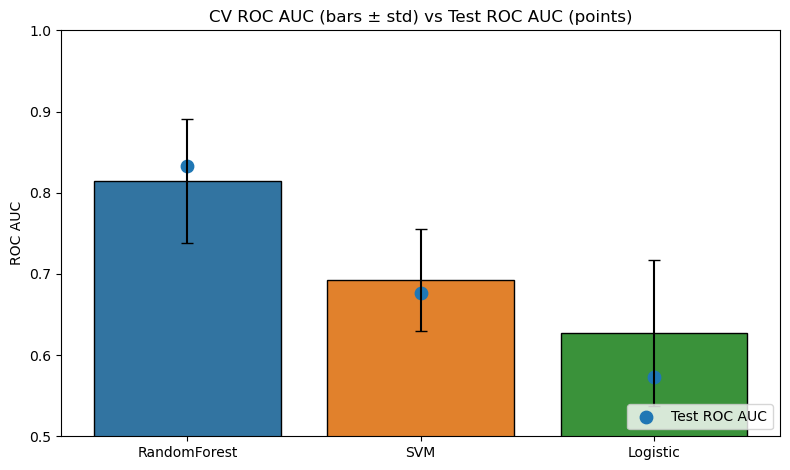

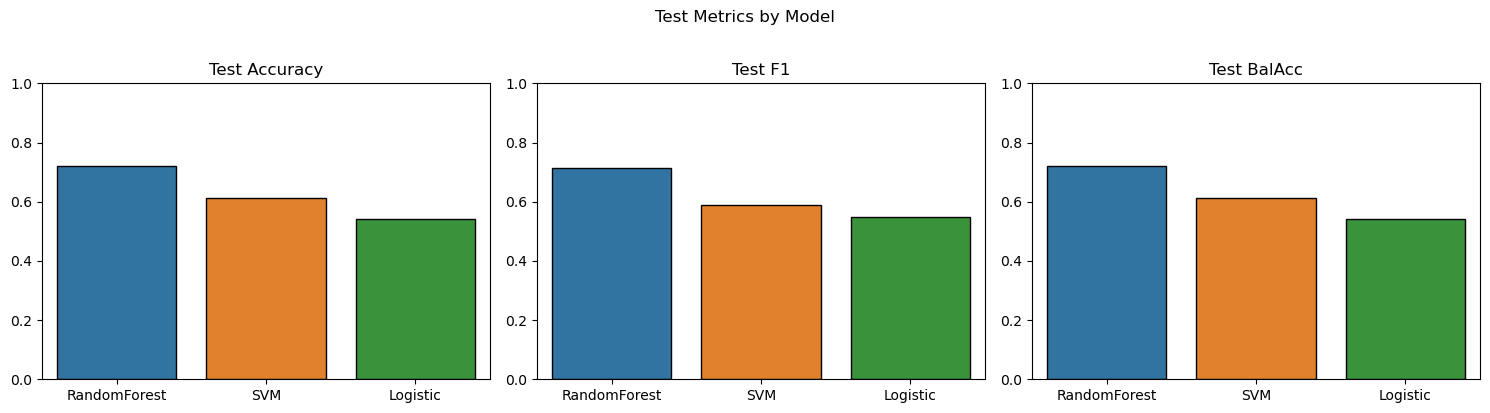

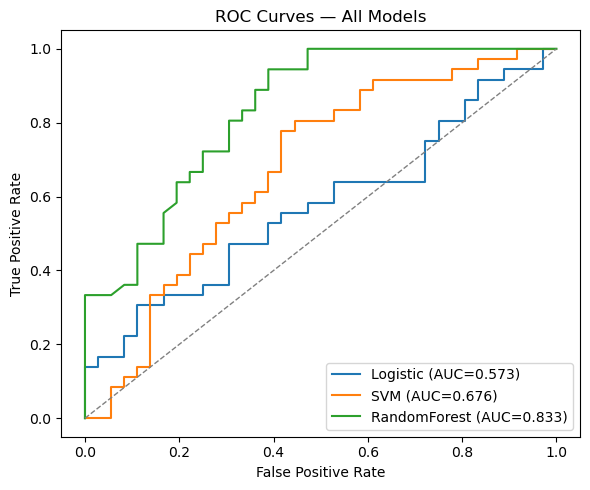


Selected by TEST AUC: RandomForest

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.71      0.75      0.73        36
        ADHD       0.74      0.69      0.71        36

    accuracy                           0.72        72
   macro avg       0.72      0.72      0.72        72
weighted avg       0.72      0.72      0.72        72



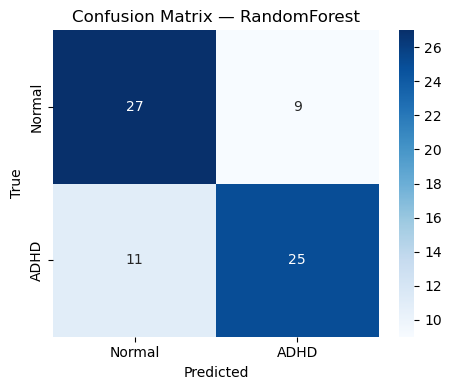


Top features (importance / |coef|):
  Hurst Exponent                           0.1011
  AR(1) Coefficient                        0.1006
  Wavelet cA Mean (db4)                    0.0994
  Negative Peak Amplitude                  0.0825
  Wavelet cA Entropy (bits)                0.0813
  Band Power                               0.0808
  Histogram Entropy (bits)                 0.0766
  Variance                                 0.0757
  Positive Peak Amplitude                  0.0720
  Amplitude                                0.0695
  Wavelet cD Entropy (bits)                0.0670
  Median                                   0.0656
  Wavelet cD Mean (db4)                    0.0278
  Mean                                     0.0000


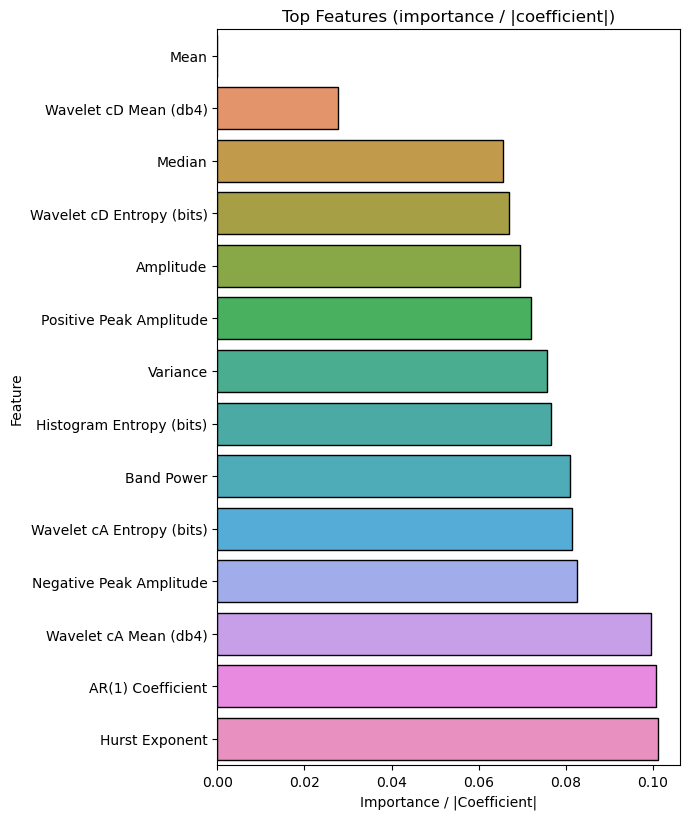

In [18]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score, f1_score, balanced_accuracy_score, accuracy_score,
    precision_score, recall_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1) Load & clean
# -----------------------------
file_path = r'E:\new adhd\alpha_features.csv'  # <-- change if needed
df = pd.read_csv(file_path)

# Standardize column names & ensure "Label"
df.columns = [c.strip() for c in df.columns]
if 'label' in df.columns and 'Label' not in df.columns:
    df = df.rename(columns={'label': 'Label'})

# Normalize labels to 'Normal' / 'ADHD'
def to_normal_adhd(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # numeric 0/1 labels
    try:
        v = float(s)
        return 'ADHD' if v == 1 else 'Normal'
    except ValueError:
        pass
    # textual variants
    if s in {'adhd', 'patient', 'case', 'affected'}:
        return 'ADHD'
    if s in {'normal', 'control', 'healthy'}:
        return 'Normal'
    return 'ADHD' if 'adhd' in s else 'Normal'

df['Label'] = df['Label'].apply(to_normal_adhd)
df = df.dropna(subset=['Label']).reset_index(drop=True)

# Numeric features (exclude non-features if present)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['ID', 'Label', 'Unnamed: 0']:
    if col in num_cols:
        num_cols.remove(col)

X = df[num_cols].values
y = df['Label'].map({'Normal': 0, 'ADHD': 1}).astype(int).values
feature_names = num_cols

print(f"Samples: {len(y)} | Features: {len(feature_names)}")

# -----------------------------
# 2) Train/Test split (stratified)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 3) CV, pipelines, and grids
# (classes are balanced → we don't set class_weight)
# -----------------------------
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

pipe_lr  = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k='all')),
    ('clf', LogisticRegression(max_iter=5000, solver='saga', random_state=42))
])

pipe_svm = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k='all')),
    ('clf', SVC(probability=True, kernel='rbf', random_state=42))
])

pipe_rf  = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(random_state=42))
])

# k choices for feature selection
k_choices = [min(10, X_train.shape[1]), min(20, X_train.shape[1]), 'all']

param_lr = {
    'select__k': k_choices,
    'clf__C': [0.01, 0.1, 1, 10, 100]
}
param_svm = {
    'select__k': k_choices,
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']
}
param_rf = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5]
}

models = {
    'Logistic': (pipe_lr, param_lr),
    'SVM': (pipe_svm, param_svm),
    'RandomForest': (pipe_rf, param_rf)
}

# -----------------------------
# 4) Grid search + collect metrics
# -----------------------------
rows = []
best_estimators = {}
best_by_auc_name, best_auc_cv = None, -np.inf

for name, (pipe, grid) in models.items():
    gs = GridSearchCV(
        pipe, param_grid=grid, cv=cv,
        scoring='roc_auc', n_jobs=-1, refit=True, verbose=0
    )
    gs.fit(X_train, y_train)

    # CV mean/std of best
    cv_mean = gs.best_score_
    best_idx = gs.best_index_
    cv_std = gs.cv_results_['std_test_score'][best_idx]

    # Test metrics
    best_est = gs.best_estimator_
    y_prob = best_est.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    test_auc = roc_auc_score(y_test, y_prob)
    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    f1       = f1_score(y_test, y_pred)
    prec     = precision_score(y_test, y_pred, zero_division=0)
    rec      = recall_score(y_test, y_pred, zero_division=0)

    rows.append({
        'Model': name,
        'CV_ROC_AUC_Mean': cv_mean,
        'CV_ROC_AUC_STD': cv_std,
        'Test_ROC_AUC': test_auc,
        'Test_Accuracy': acc,
        'Test_BalAcc': bal_acc,
        'Test_F1': f1,
        'Test_Precision': prec,
        'Test_Recall': rec,
        'Best_Params': gs.best_params_
    })
    best_estimators[name] = best_est

    if cv_mean > best_auc_cv:
        best_auc_cv = cv_mean
        best_by_auc_name = name

# Results table
results_df = pd.DataFrame(rows).sort_values('Test_ROC_AUC', ascending=False).reset_index(drop=True)
print("\n=== Model Comparison (sorted by Test ROC AUC) ===")
print(results_df[['Model','CV_ROC_AUC_Mean','CV_ROC_AUC_STD',
                  'Test_ROC_AUC','Test_Accuracy','Test_BalAcc','Test_F1',
                  'Test_Precision','Test_Recall','Best_Params']])

# Save table next to data
out_csv = os.path.join(os.path.dirname(file_path), 'alpha_model_comparison.csv')
results_df.to_csv(out_csv, index=False)
print(f"\nSaved comparison table to: {out_csv}")

# -----------------------------
# 5) Plots: CV vs Test AUC
# -----------------------------
plt.figure(figsize=(8, 4.8))
ax = sns.barplot(data=results_df, x='Model', y='CV_ROC_AUC_Mean', edgecolor='black')
# error bars for CV std
for i, row in results_df.iterrows():
    ax.errorbar(i, row['CV_ROC_AUC_Mean'], yerr=row['CV_ROC_AUC_STD'],
                fmt='none', ecolor='black', capsize=4)
# overlay Test AUC as points
plt.scatter(range(len(results_df)), results_df['Test_ROC_AUC'], marker='o', s=80, label='Test ROC AUC')
plt.ylim(0.5, 1.0)
plt.title('CV ROC AUC (bars ± std) vs Test ROC AUC (points)')
plt.ylabel('ROC AUC'); plt.xlabel('')
plt.legend(loc='lower right')
plt.tight_layout(); plt.show()

# -----------------------------
# 6) Plots: Accuracy, F1, Balanced Accuracy
# -----------------------------
metrics_to_plot = ['Test_Accuracy', 'Test_F1', 'Test_BalAcc']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, met in zip(axes, metrics_to_plot):
    sns.barplot(data=results_df, x='Model', y=met, ax=ax, edgecolor='black')
    ax.set_ylim(0.0, 1.0)
    ax.set_title(met.replace('_', ' '))
    ax.set_xlabel(''); ax.set_ylabel('')
fig.suptitle('Test Metrics by Model', y=1.02)
plt.tight_layout(); plt.show()

# -----------------------------
# 7) ROC Curves (all models)
# -----------------------------
plt.figure(figsize=(6, 5))
for name, est in best_estimators.items():
    y_prob = est.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — All Models')
plt.legend(loc='lower right')
plt.tight_layout(); plt.show()

# -----------------------------
# 8) Confusion matrix + report of the top Test AUC model
# -----------------------------
best_test_name = results_df.iloc[0]['Model']
best_model = best_estimators[best_test_name]
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print(f"\nSelected by TEST AUC: {best_test_name}")
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, target_names=['Normal','ADHD']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','ADHD'], yticklabels=['Normal','ADHD'])
plt.title(f'Confusion Matrix — {best_test_name}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

# -----------------------------
# 9) Top features (if model exposes them)
# -----------------------------
def show_top_features(estimator, feat_names, topn=15):
    importances = None
    # RandomForest
    if hasattr(estimator, 'named_steps') and 'clf' in estimator.named_steps:
        clf = estimator.named_steps['clf']
        # RF importances
        if hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_
            # if SelectKBest existed earlier in pipeline, map names
            if 'select' in estimator.named_steps and hasattr(estimator.named_steps['select'], 'get_support'):
                mask = estimator.named_steps['select'].get_support()
                feat_names = [f for f, m in zip(feat_names, mask) if m]
        # Logistic coefficients
        elif hasattr(clf, 'coef_'):
            coef = clf.coef_.ravel()
            importances = np.abs(coef)
            if 'select' in estimator.named_steps and hasattr(estimator.named_steps['select'], 'get_support'):
                mask = estimator.named_steps['select'].get_support()
                feat_names = [f for f, m in zip(feat_names, mask) if m]
    if importances is None:
        print("Model does not expose feature importances/coefficients.")
        return

    order = np.argsort(importances)[::-1][:min(topn, len(importances))]
    names = [feat_names[i] for i in order][::-1]
    vals  = [importances[i] for i in order][::-1]

    print("\nTop features (importance / |coef|):")
    for n, v in zip(names[::-1], vals[::-1]):
        print(f"  {n:40s} {v:.4f}")

    plt.figure(figsize=(7, 0.45*len(names)+2))
    sns.barplot(x=vals, y=names, edgecolor='black')
    plt.title('Top Features (importance / |coefficient|)')
    plt.xlabel('Importance / |Coefficient|'); plt.ylabel('Feature')
    plt.tight_layout(); plt.show()

# Map selected feature names if SelectKBest kept a subset (we derive from logistic pipeline)
final_feat_names = feature_names
if hasattr(best_model, 'named_steps') and 'select' in best_model.named_steps:
    sel = best_model.named_steps['select']
    if hasattr(sel, 'get_support'):
        mask = sel.get_support()
        final_feat_names = [f for f, m in zip(feature_names, mask) if m]

show_top_features(best_model, final_feat_names, topn=15)
